# Feature Engineering
Our dataset has numerous issues and inconsistancies. The first thing we should handle is missing values. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df = pd.read_csv('hotel_booking.csv')
df.isnull().sum()[df.isnull().sum() > 0]
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card'],
      dtype='object')

It looks like there are 4 fields with missing values. For the `children` field, we can just set the missing values to 0, because the majority of entries in the column are 0. For the `country` field, we can set the missing values to UNK, which is an otherwise unused 3 letter code that can stand for unkown country. The last two fields: `agent` and `company` have the vast majority of our missing values, and are harder to handle. I'm not sure what they are supposed to mean, but they are all positive integers, so we can use 0 to symbolize unknown.

In [2]:
df["children"].fillna(0, inplace=True)
df["country"].fillna("UNK", inplace=True)
df["agent"].fillna(0, inplace=True)
df["company"].fillna(0, inplace=True)

Our analysis will focus on the categorical data of room types. In order to make this easier to work with, we'll convert the room types from characters to integers (A becomes 1, B becomes 2, etc.).

In [3]:
df["assigned_room_type"].value_counts()
df['assigned_room_type'] = df["assigned_room_type"].apply(ord) - 64

It's worth going through our data and removing fields that don't provide useful or relevent information. Fields like the `credit_card` are effectively random, and aren't worth carrying through our computations. Our analysis methods work best with numerical data, so we will be prioritizing the numerical fields.

In [4]:
df = df[['lead_time', 
         'arrival_date_week_number', 
         'stays_in_weekend_nights', 
         'stays_in_week_nights', 
         'adults',
         'children',
         'babies',
         'previous_cancellations',
         'previous_bookings_not_canceled',
         'assigned_room_type',
         'booking_changes',
         'days_in_waiting_list',
         'adr',
         'required_car_parking_spaces',
         'total_of_special_requests']]
df['children'] = df['children'].astype(int)

We should now have a data set that is ready for our analysis.

# Dimensionality Reduction
A valuable process we can apply to our data is called dimensionality reduction. This can be accomplished in a few ways, but essentially, the goal is to reduce the number of fields we need to deal with, while minimizing any loss in variance/information. In order for our data to be prepared for these sorts of calculations, it needs to be standardized. This prevents certain fields from outweighing others simply because the values in the field are larger or more variant.

In [5]:
normdf = df.copy()
for col in normdf.select_dtypes(include=['number']).columns :
    normdf[col] = (normdf[col] - normdf[col].mean()) / normdf[col].std()

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,assigned_room_type,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,2.227042,-0.01214,-0.928887,-1.310234,0.247896,-0.260658,-0.081579,-0.103179,-0.091554,0.353097,4.260083,-0.131923,-2.015030,-0.254872,-0.720691
1,5.923360,-0.01214,-0.928887,-1.310234,0.247896,-0.260658,-0.081579,-0.103179,-0.091554,0.353097,5.793107,-0.131923,-2.015030,-0.254872,-0.720691
2,-0.907810,-0.01214,-0.928887,-0.786204,-1.478441,-0.260658,-0.081579,-0.103179,-0.091554,0.353097,-0.338988,-0.131923,-0.530933,-0.254872,-0.720691
3,-0.851664,-0.01214,-0.928887,-0.786204,-1.478441,-0.260658,-0.081579,-0.103179,-0.091554,-0.704311,-0.338988,-0.131923,-0.530933,-0.254872,-0.720691
4,-0.842306,-0.01214,-0.928887,-0.262173,0.247896,-0.260658,-0.081579,-0.103179,-0.091554,-0.704311,-0.338988,-0.131923,-0.075810,-0.254872,0.540664


Now that our data is standardized, we can implement our first version of dimensionality reduction: PCA. In PCA, we consider each field as a vector, and translate these vectors to a new basis, maximizing the variance capture by each following vector. This allows us to rely on just the first few vectors of the set, since they capture a large portion of the variance.

In [6]:
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pcafeat = pca.fit_transform(normdf)

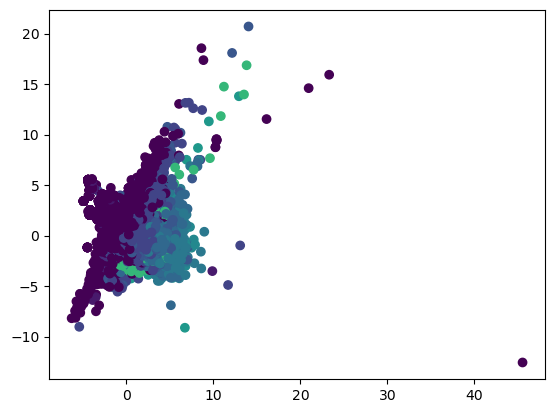

In [7]:
import matplotlib.pyplot as plt
plt.scatter(pcafeat[:, 0], pcafeat[:, 1], c=df['assigned_room_type'])
plt.show()

Instead of using PCA, we could also try t-SNE. Instead of using basis transformations, we can systemtically judge the distance between data points, and map them onto fewer dimensions. I found that this took far more computational power than PCA, so I had to run t-SNE on a sample size of 1000, rather than the whole data set. Since the sample is random, the plot looks slightly different each time it is generated.

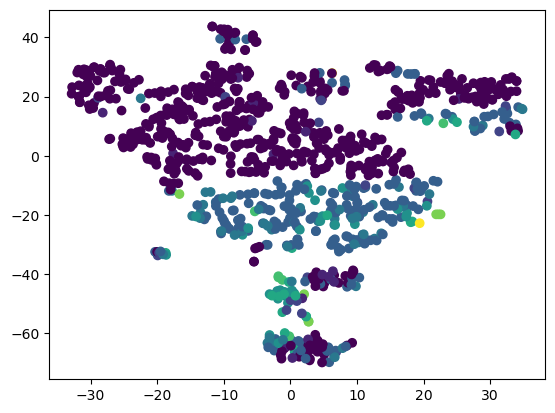

In [8]:
from sklearn.manifold import TSNE
import numpy as np

tsne = TSNE()
sampnorm = normdf.sample(1000)
tsnefeat = tsne.fit_transform(sampnorm)
plt.scatter(tsnefeat[:, 0], tsnefeat[:, 1], c=sampnorm['assigned_room_type'])
plt.show()

# Clustering
In clustering, we try to group data into distinct clusters. This can be used to find pattarens in data that might not be immediately intuitive, and allows us to make generalizations on the data. One method to do this is K-Means, which systematically minimizes the distance between each data point and its cluster center. It's not necessarily obvious how many cluster we should be generating. There are a few ways to find answer to this. I chose the elbow method.

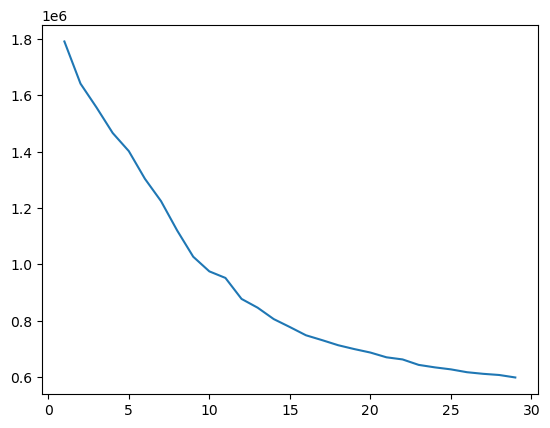

In [9]:
from sklearn.cluster import KMeans

# List to store inertia for each k
inertia = []

# Range of clusters to try
cluster_range = range(1, 30)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pcafeat)  # Use PCA-reduced features or original features
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.plot(cluster_range, inertia)
plt.show()

It looks like we want around 10 clusters based on this plot.

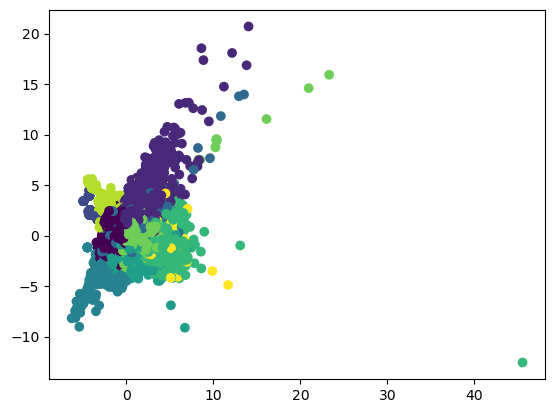

In [10]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(pcafeat)
plt.scatter(pcafeat[:,0], pcafeat[:,1], c=kmeans.labels_)
plt.show()

Another method is DBSCAN, which makes a distinction with areas with densely packed data points that become clusters, and areas with more sparse data points, which are regarded as noise.

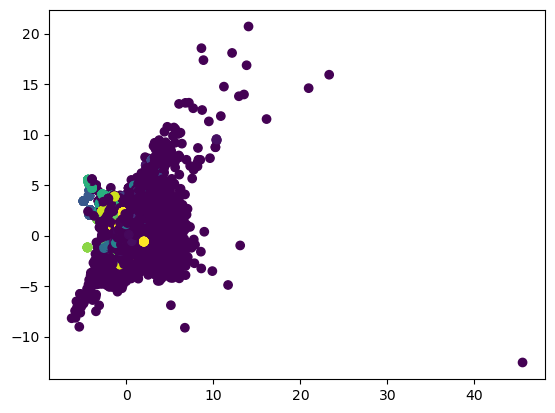

In [11]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscanlab = dbscan.fit_predict(pcafeat)
plt.scatter(pcafeat[:, 0], pcafeat[:, 1], c=dbscanlab)
plt.show()

# Analysis and Discussion
Our analysis made it clear that predictable groups that register for given room types. I attempted this analysis with and without data normalization, and the normalization massively improved results